<a href="https://colab.research.google.com/github/TravellerOnCode/Experiments_With_Twitter_US_Airlines_Sentiment_Dataset/blob/main/Experiments_With_Twitter_US_Airlines_Sentiment_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge: ***ULMFiT Sentiment: Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment***

*Sentiment Analysis and proper labelling of reviews have been one of the most important problem in terms of business perspective. In today's world, sentiment analysis and user feedbacks are very important. Airlines or any industry have changed the way they were functioning till now, so in this new system user feedbacks needs to be addressed with utmost important especially the negative sentiment. Hence i believe this particular challenge has a greater significance and greater impact in the real world.* 

# Problem Statement:
*The Problem Statement here is that, we need to classify the tweets into 3 different classes positive, neutral and negative. Hence, this is the case of a Multi-Class Classification problem.*

# Background Work:
*While researching on this problem, I came across this [research paper](http://cs229.stanford.edu/proj2016spr/report/042.pdf) by Stanford where they have got an accuracy of around 80% using SVM. In the conclusion, the paper says that SVM worked better than deep learning appoaches, the reason behind this can be the lack of sufficient data points.*

*In another [research paper](https://cs224d.stanford.edu/reports/YuanYe.pdf), the researcher have got a highest accuracy of 84% using RNNs. For my experiment I have taken these two results as benchmark and would try to improve these results*

# Approach:

*The approach will be a two way approach, at first we will try out various supervised learning algorithms and then tey to compare their performances with semi-supervised ULMFit Model.*

# Evaluation Metrics:

*Accuracy is not always the best measure when dealing with Multi-Class Classification because if the dataset is imbalanced, accuracy won't be an effective metric. Hence for this particular experiment we will use:*
 * *Precision & Recall*
          - Precision gives a measure of the proprtion of predicted class X is actually class X.
          - Recall on the other hand is a measure of what proportion of class X is correctly predicted as class X.
          
 * *Confusion Matrix*


To take a look at the overall results from all the models head over to the section "Summary of all Classifiers"

**Contents**

> The structure of the notebook is as follows:


*   Load Data
*   Exploratory Data Analysis
*   **Supervised Learning**
1.  Data Cleaning & Wrangling
2.  Feature Engineering
3.  Word Based Features
3.  Training and Testing Models

*   **Semi - Supervised Learning : ULMFit**
1. Load the dataset and setup fast.ai
2. Test/Train/Valid Split
3. Preparing the data for the Language Model
4. Train the language model
5. Setting up the Classifier
6. Train the Classifier
7. Testing and Predictions

* **ME-ULMFit (Metadata Enhanced ULMFit)**
* Summary of all Classifiers
* References






# Load Data

The Dataset is a Kaggle Dataset named [Twitter US Airlines Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv).

I have downloaded the dataset from Kaggle and uploaded it in a personal github repo. 
[Link to the dataset](https://github.com/TravellerOnCode/Experiments_With_Twitter_US_Airlines_Sentiment_Dataset/blob/master/Tweets.csv?raw=true)

In [ ]:
import requests, zipfile, io
import pandas as pd
pd.options.mode.chained_assignment = None

#the csv is stored in a github repo
r = requests.get( "https://github.com/TravellerOnCode/Experiments_With_Twitter_US_Airlines_Sentiment_Dataset/blob/master/Tweets.csv?raw=true" ) 
df = pd.read_csv(io.BytesIO(r.content))
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


# Exploratory Data Analysis

Exploratory Data Analysis is a process by which we can get an overview of the dataset. Before starting with this dataset we will try to study the dataset.

In [ ]:
#Load the libraries
# For visualizations
import matplotlib.pyplot as plt
import re
import string
import math

In [ ]:
#the number of null values present in each column
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [ ]:
#converting this number into percentage
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

We can see that columns like airline_sentiment_gold, negativereason_gold, tweet_coord have more than 90% of their values as NULL. Hence, let's drop these columns and use the rest of the dataset for EDA.



In [ ]:
#Rejecting columns that have NAN values > 90%
df_new = df.drop(columns=['airline_sentiment_gold','negativereason_gold','tweet_coord'])
df_new.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64

**Examine a few Tweets**

In [ ]:
#Examining a few Tweets
print('Tweet Sentiment :',df_new['airline_sentiment'][1])
print('Tweet :',df_new['text'][1])

Tweet Sentiment : positive
Tweet : @VirginAmerica plus you've added commercials to the experience... tacky.


In [ ]:
#Examining a few Tweets
print('Tweet Sentiment :',df_new['airline_sentiment'][0])
print('Tweet :',df_new['text'][0])

Tweet Sentiment : neutral
Tweet : @VirginAmerica What @dhepburn said.


In [ ]:
#Examining a few Tweets
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

Tweet Sentiment : negative
Tweet : @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


So we have three types of Tweets. The Tweets are not in the proper format so we need to clear them out

**Examine the frequency of each sentiment airlines wise**

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64





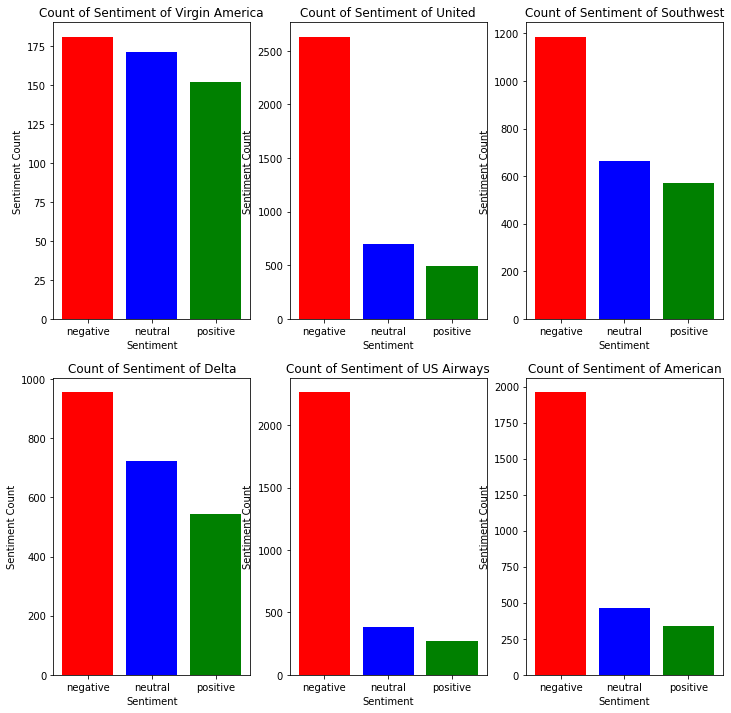

In [ ]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
print('\n\n')
airlines = list(df_new['airline'].unique())
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'blue', 'green'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiment of '+i)

There are few insights that can be drawn from these plots:


*  Virgin America and Delta can be considered as a better airlines than the rest, since the difference between the number of negative tweets and positive tweets is less as compare to other airlines.
*   US Airways and American airlines has the largest difference in count of negative and positive tweets. Hence these airlines are not performing well.
* The dataset is imbalanced since the number of negative tweets in each sample is greater than the number of positive and neutral tweets.



**Examining the most used words**

In [ ]:
from wordcloud import WordCloud,STOPWORDS

In [ ]:
def display_word_cloud(new_df):
  words = ' '.join(new_df['text'])
  cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
  wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
  plt.figure(1,figsize=(12, 12))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

Most used words in Negative Tweets


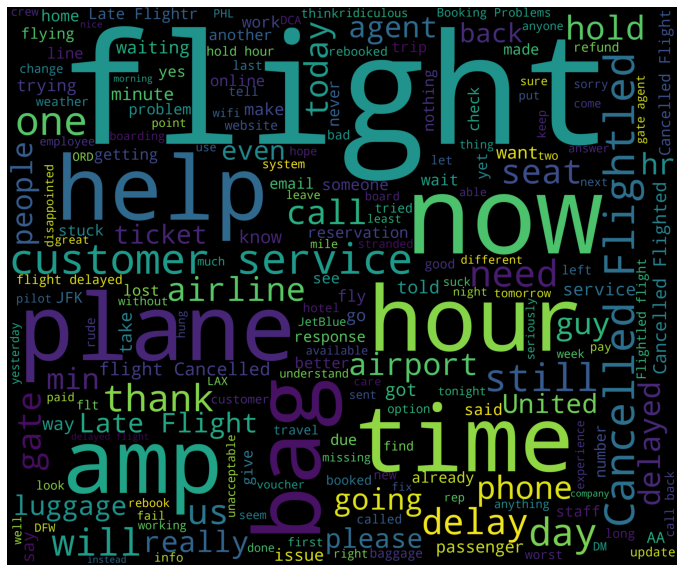



 Most used words in Positive Tweets


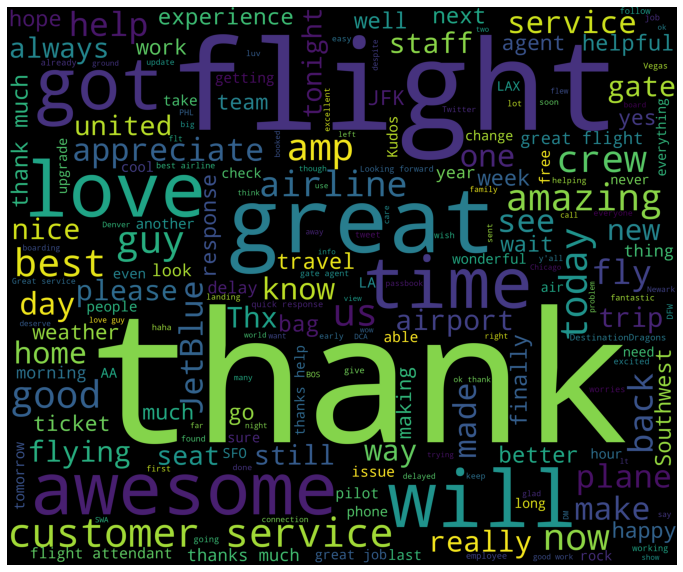



 Most used words in Neutral Tweets


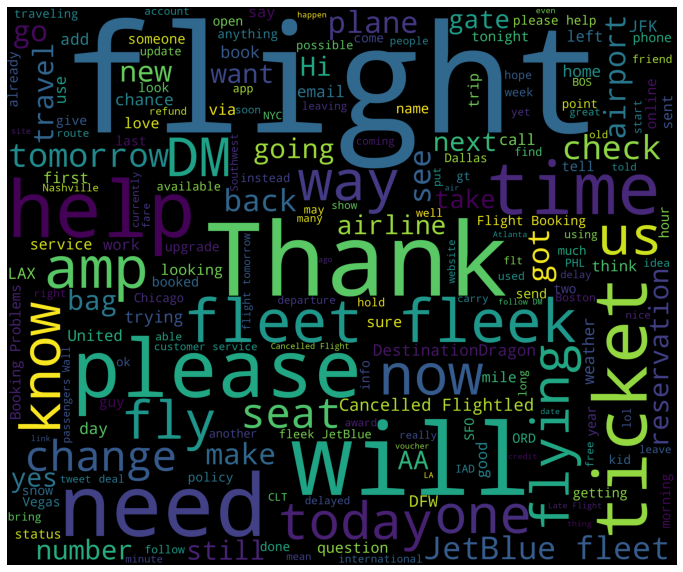

In [ ]:
print('Most used words in Negative Tweets')
new_df=df[df['airline_sentiment']=='negative']
display_word_cloud(new_df)

print('\n\n Most used words in Positive Tweets')
new_df=df[df['airline_sentiment']=='positive']
display_word_cloud(new_df)

print('\n\n Most used words in Neutral Tweets')
new_df=df[df['airline_sentiment']=='neutral']
display_word_cloud(new_df)


**Examine the reasons for negative tweets**

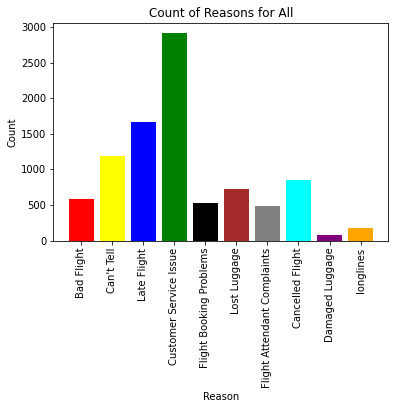

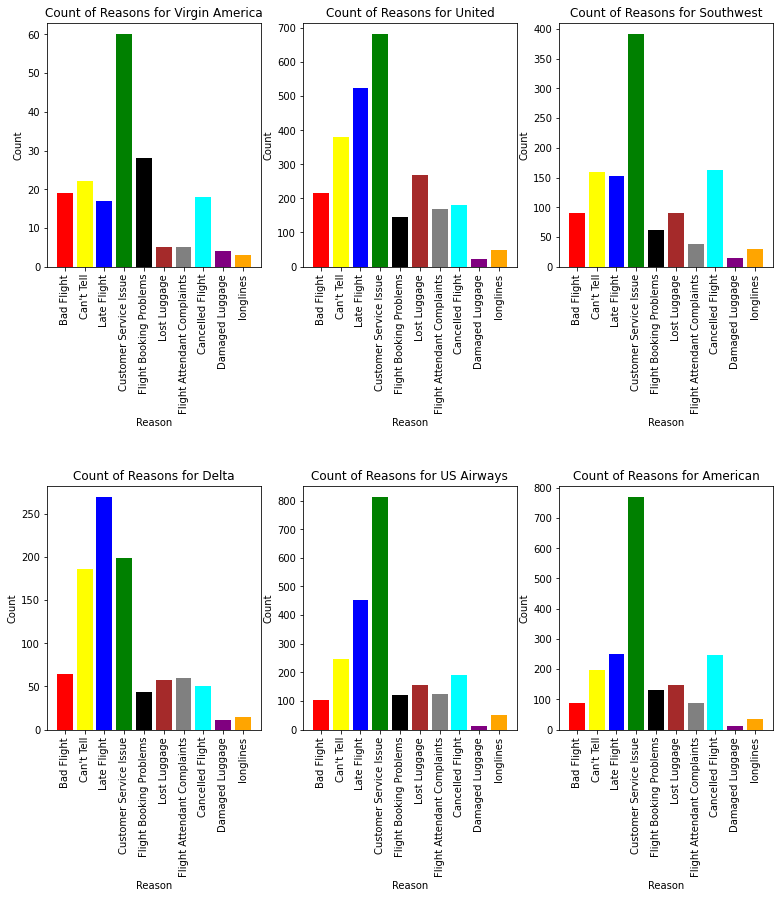

In [ ]:
#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

From these plots we can see that 'customer service issue' have been the biggest issue in US Airlines, second being flight delays.

The reason for negative tweets in each airline is as follows:

* Virgin America, United, Southwest, US Airways, American - customer service issue
* Delta - Late Flight

In [ ]:
print("Total number of re-tweets for each sentiment \n ",df.groupby('airline_sentiment')['retweet_count'].sum().sort_values(ascending=False))


Total number of re-tweets for each sentiment 
  airline_sentiment
negative    857
neutral     189
positive    164
Name: retweet_count, dtype: int64


We can see that negative tweets gets more retweets than positive and neutral ones. The frequency of tweets is not the correct measure since the number of negative tweets is also more. Hence lets go and calculate the % of retweets.

In [ ]:
c1 = df['airline_sentiment'].value_counts().sort_values(ascending=False)
c2 = df.groupby('airline_sentiment')['retweet_count'].sum().sort_values(ascending=False)
print('Percentage of Re-Tweets per sentiment class: \n',c2*100/c1)


Percentage of Re-Tweets per sentiment class: 
 airline_sentiment
negative    9.337546
neutral     6.098742
positive    6.940330
dtype: float64


The conclusion remains the same that negative tweets gets more retweets than the postitive, neutral tweets.

#Supervised Learning #1

Firstly we will try the classic supervised learning approaches like LogisticRegression, RandomForest, DecisionTree Classifiers.

# #1.a Data Cleaning & Wrangling

In [ ]:

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)



Since the tweets contain a lot of tagged user names, money amounts and number so to keep the meaning of them intact let's replace them with meaningful words.

All Company names -> company

All User Names -> name

Money amount -> money

Number -> number

This will also prevent the model from getting biased towards a particular airlines as our sole reason is to do analysis on the tweets.

In [ ]:
#Replace the Twitter handles with tags
def replace_tags(df_new):
  company_list = ['@VirginAmerica','@AmericanAir','@USAirways','@usairw','@USAirw','@usairways','@JetBlue','@jetBlue','@SouthwestAir','@united']
  for ind in df_new.index:
    s = df_new['text'][ind]
    s1 = ch = ""
    w = s.split(' ')
    #print(w)
    for i in range(len(w)):
      try:
        if w[i][0] == '@':
          if w[i] in company_list:
            ch = 'Company'
          else:
            ch = 'Name'
        elif w[i][0] == '$' :
            ch = 'money'
        elif (w[i][0].isdigit()):
            ch = 'number'
        else:
          ch = w[i]
      except:
        a =0
      s1 = s1 + " " + ch
    df_new['text'][ind] = s1

  return df_new


In [ ]:
#Examining a few Tweets
print('Before Data Wrangling')
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

Before Data Wrangling
Tweet Sentiment : negative
Tweet : @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


In [ ]:
def data_wrangling(df_new):
  # Expanding Contractions in the reviews
  df_new['text']=df_new['text'].apply(lambda x:expand_contractions(x))
  print('Contractions expanded !')
  df_new = replace_tags(df_new)
  print('Profile Tags replaced !')

data_wrangling(df_new)

Contractions expanded !
Profile Tags replaced !


In [ ]:
#Examining a few Tweets
print('After Replacements')
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

After Replacements
Tweet Sentiment : negative
Tweet :  Company seriously would pay money a flight for seats that did not have this playing.
it is really the only bad thing about flying VA


Thus the numbers and tags have been replaced with meaningful words. Additionally words like didn't , haven't have been expanded in the form of 'did not' and 'have not'.

This will help greatly in preparing the features.

**Clean the dataset**

In [ ]:
#df_new['text']=df_new['text'].apply(lambda x: x.lower())
df_new['text']=df_new['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
#Removing Punctuations
df_new['text']=df_new['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
#Removing extra spaces
df_new['text']=df_new['text'].apply(lambda x: re.sub(' +',' ',x))

Note: We did not convert all the letters to lower case, this is to preserve the case sensitivity so that they can be used as a feature column while feature engineering.

In [ ]:
#Examining a few Tweets
print('After Data Cleaning')
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

After Data Cleaning
Tweet Sentiment : negative
Tweet :  Company seriously would pay money a flight for seats that did not have this playing
it is really the only bad thing about flying VA


In [ ]:
#df_new.to_csv('tweets_cleaned.csv')

# #1.b Feature Engineering

Creating features out of the dataset

In [ ]:
#list of columns
df_new.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64

For creating the feature columns we select 

**Creating Text Based Features**

In [ ]:
#taking only the text data column lets try to do Feature Engineering on this
text_features = df_new[['text']]
text_features.head(3)

,text
0,Company What Name said
1,Company plus you have added commercials to th...
2,Company I did not today Must mean I need to t...


In [ ]:
import string
#The Count of Characters in each tweet
text_features['char_count'] = text_features['text'].apply(len)
#The number of words in each tweet
text_features['word_count'] = text_features['text'].apply(lambda x: len(x.split()))
#Words density is a measure of how big the words are in a particular tweet
text_features['word_density'] = text_features['char_count'] / (text_features['word_count']+1)
#text_features['punctuation_count'] = text_features['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
#Title Case count gives a measure of the Names or any specific location that have been used in a Tweet 
text_features['title_word_count'] = text_features['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
#Gives the count of the Upper Case Words
text_features['upper_case_word_count'] = text_features['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


In [ ]:
text_features.head(5)

,text,char_count,word_count,word_density,title_word_count,upper_case_word_count
0,Company What Name said,23,4,4.600000,3,0
1,Company plus you have added commercials to th...,64,10,5.818182,1,0
2,Company I did not today Must mean I need to t...,62,13,4.428571,4,2
3,Company it is really aggressive to blast obno...,116,18,6.105263,1,0
4,Company and it is a really big bad thing abou...,50,11,4.166667,1,0


 **Feature extraction with TextBlob**

When doing a sentiment analysis we are trying to determine the attitude or the emotion of the person who is writing the review whether the writing is positive, negative or neutral.

TextBlob has a feature for calculating **polarity** and **subjectivity** of the writing. 

Polarity is a value that ranges from [-1,1] where -1 denotes negative and +1 denotes positive. 
Subjectivity refers to personal opinions, emotion or judgement. This is also a float value and ranges between [0,1]

In [ ]:
import textblob

In [ ]:
#Lets try it out on some reviews
p = "@VirginAmerica plus you've added commercials to the experience... tacky."
print(textblob.TextBlob(p).sentiment)
n = "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA"
print(textblob.TextBlob(n).sentiment)
nn = "@VirginAmerica What @dhepburn said."
print(textblob.TextBlob(nn).sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=-0.2083333333333333, subjectivity=0.6333333333333333)
Sentiment(polarity=0.0, subjectivity=0.0)


The second review has a negative polarity which shows that it is a negative review (which is right) rest of the reviews are classified as neutral. 

This polarity and subjectivity can be added as a feature of this the dataset

In [ ]:
sentiment_obj = text_features['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
text_features['Polarity'] = [obj.polarity for obj in sentiment_obj.values]
text_features['Subjectivity'] = [obj.subjectivity for obj in sentiment_obj.values]

In [ ]:
text_features.head(3)

,text,char_count,word_count,word_density,title_word_count,upper_case_word_count,Polarity,Subjectivity
0,Company What Name said,23,4,4.600000,3,0,0.0000,0.0000
1,Company plus you have added commercials to th...,64,10,5.818182,1,0,0.0000,0.0000
2,Company I did not today Must mean I need to t...,62,13,4.428571,4,2,-0.3125,0.6875


Now that we have a set of features lets train a basic model, a logistic regression model on this dataset

**Training and Test set splitting**

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_features.drop(['text'],axis=1), df_new['airline_sentiment'], random_state=42)
X_train.shape, X_test.shape

((10980, 7), (3660, 7))

In [ ]:
Counter(y_train), Counter(y_test)

(Counter({'negative': 6838, 'neutral': 2361, 'positive': 1781}),
 Counter({'negative': 2340, 'neutral': 738, 'positive': 582}))

Converting the labels into numerics:

* 0 -> Negative Tweet
* 1 -> Neutral Tweet
* 2 -> Positive Tweet

In [ ]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(y_train)
Y_train = encoder.transform(y_train)

# encoding test labels 
encoder.fit(y_test)
Y_test = encoder.transform(y_test)


**Algorithm 1: Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lr = LogisticRegression(C=1, random_state=42, solver='liblinear')

In [ ]:
lr.fit(X_train, Y_train)
predictions = lr.predict(X_test)

#Generating evaluation Metrics
report_lr_word_features = classification_report(Y_test, predictions)
matrix_lr_word_features = confusion_matrix(Y_test, predictions)
print("The Classification Report")
print(report_lr_word_features)
print("The Confusion Matrix")
pd.DataFrame(matrix_lr_word_features)


The Classification Report
              precision    recall  f1-score   support

           0       0.75      0.92      0.82      2340
           1       0.45      0.26      0.33       738
           2       0.54      0.33      0.41       582

    accuracy                           0.69      3660
   macro avg       0.58      0.50      0.52      3660
weighted avg       0.65      0.69      0.66      3660

The Confusion Matrix


,0,1,2
0,2153,102,85
1,472,189,77
2,263,129,190


**Trying another algorithm - Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fitting Random Forest Classification to the Training set
classifier_ = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier_.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Predicting the Test set results
y_pred = classifier_.predict(X_test)

#Generating evaluation Metrics
report_rfc_word_features = classification_report(Y_test, y_pred)
matrix_rfc_word_features = confusion_matrix(Y_test, y_pred)
print("The Classification Report")
print(report_rfc_word_features)
print("The Confusion Matrix")
pd.DataFrame(matrix_rfc_word_features)


The Classification Report
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      2340
           1       0.43      0.29      0.35       738
           2       0.55      0.43      0.48       582

    accuracy                           0.69      3660
   macro avg       0.58      0.53      0.55      3660
weighted avg       0.66      0.69      0.67      3660

The Confusion Matrix


,0,1,2
0,2053,186,101
1,420,215,103
2,235,96,251


We can see there's no significant improvement as such, Random Forest Classifier which is a better classifier still has the same accuracy. Also, there is no significant improvement in the precision and recall too.

Examining the confusion matrix, one can say that the model works well on negative but fails miserably on Positive and Neutral Tweets. As one can see, the random forest classifier classifies 2053 tweets as 0 (negative) correctly but also classifies 420 neutral tweets as negative and 235 positive negative tweets as negative. This number is greater than the number of positive and negative tweets that have been classified correctly.

This is due to two reasons:
* The dataset is imbalanced
* The features that have been used is not enough to classify the tweets.

# #1.c Word Based Features

Using the Count based and sentiment based features we got the results as shown above, which is pretty good as a base model. Now, lets do more Feature engineering so that the model can learn the sentiments more precisely.  

**Text Pre-processing and Data Wrangling**

Removing Stop words

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')

stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

#analyse the most negative words and remove according to the dataset DO IT AFTER EDA


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# stopwords removal
def remove_stopwords(row):
  row = ' '.join([word for word in row.split() if word not in stop_words])
  return row

text_features['Clean_Text'] = [remove_stopwords(row) for row in text_features['text'] ]
    

In [ ]:
text_features['Clean_Text']=text_features['Clean_Text'].apply(lambda x: x.lower())
text_features.head(3)

,text,char_count,word_count,word_density,title_word_count,upper_case_word_count,Polarity,Subjectivity,Clean_Text
0,Company What Name said,23,4,4.600000,3,0,0.0000,0.0000,company what name said
1,Company plus you have added commercials to th...,64,10,5.818182,1,0,0.0000,0.0000,company plus added commercials experience tacky
2,Company I did not today Must mean I need to t...,62,13,4.428571,4,2,-0.3125,0.6875,company i not today must mean i need take anot...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(text_features['Clean_Text'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
tf_vectors = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

In [ ]:
tf_vectors.head(3)

,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aadavantage,aadelay,aadfw,aadv,aadvantage,aafail,aal,aampc,aano,aaron,aateam,aaus,ab,aback,abandon,abandoned,abandonment,abassinet,abbreve,abc,abcletjetbluestreamfeed,abcnews,abducted,abi,abidfw,abilities,ability,able,aboard,aboout,abounds,about,abq,abroad,...,yout,youth,youto,youve,youyou,yow,yponthebeat,ypu,yr,yrs,ystday,ystrdy,yuck,yucki,yulord,yuma,yummy,yup,yvonne,yvr,yxe,yxu,yyc,yyj,yyz,zabsonre,zambia,zero,zfv,zigzagging,zip,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich,zurichnew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
text_features_tf = pd.concat([text_features, tf_vectors], axis=1)
text_features_tf.head(3)

,text,char_count,word_count,word_density,title_word_count,upper_case_word_count,Polarity,Subjectivity,Clean_Text,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aadavantage,aadelay,aadfw,aadv,aadvantage,aafail,aal,aampc,aano,aaron,aateam,aaus,ab,aback,abandon,abandoned,abandonment,abassinet,abbreve,abc,abcletjetbluestreamfeed,abcnews,abducted,abi,abidfw,...,yout,youth,youto,youve,youyou,yow,yponthebeat,ypu,yr,yrs,ystday,ystrdy,yuck,yucki,yulord,yuma,yummy,yup,yvonne,yvr,yxe,yxu,yyc,yyj,yyz,zabsonre,zambia,zero,zfv,zigzagging,zip,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich,zurichnew
0,Company What Name said,23,4,4.600000,3,0,0.0000,0.0000,company what name said,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Company plus you have added commercials to th...,64,10,5.818182,1,0,0.0000,0.0000,company plus added commercials experience tacky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Company I did not today Must mean I need to t...,62,13,4.428571,4,2,-0.3125,0.6875,company i not today must mean i need take anot...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(text_features_tf.drop(['text','Clean_Text'],axis=1), df_new['airline_sentiment'], random_state=42)
X_train_.shape, X_test_.shape

((10980, 12428), (3660, 12428))

In [ ]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(y_train_)
Y_train = encoder.transform(y_train_)

# encoding test labels 
encoder.fit(y_test_)
Y_test = encoder.transform(y_test_)

The values are of various integer range so for faster computation and generalisation, we scale the feature values to a particular value.

In [ ]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
Counter(y_train_), Counter(y_test_)

(Counter({'negative': 6838, 'neutral': 2361, 'positive': 1781}),
 Counter({'negative': 2340, 'neutral': 738, 'positive': 582}))

# #1.d Training and Testing Models

With these revised set of features, we implement certain and supervised learning algorithms and try to compare their results.

**Algorithm 1: Logistic Regression**

In [ ]:
classifier_lr= LogisticRegression(C=1, random_state=42, solver='liblinear')
classifier_lr.fit(X_train_scaled, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = classifier_lr.predict(X_test_scaled)

#Generating evaluation Metrics
report_lr_word_features_tfidf = classification_report(Y_test, predictions)
matrix_lr_word_features_tfidf = confusion_matrix(Y_test, predictions)
print("The Classification Report")
print(report_lr_word_features_tfidf)
print("The Confusion Matrix")
pd.DataFrame(matrix_lr_word_features_tfidf)


The Classification Report
              precision    recall  f1-score   support

           0       0.75      0.92      0.82      2340
           1       0.45      0.26      0.33       738
           2       0.54      0.33      0.41       582

    accuracy                           0.69      3660
   macro avg       0.58      0.50      0.52      3660
weighted avg       0.65      0.69      0.66      3660

The Confusion Matrix


,0,1,2
0,2152,102,86
1,472,189,77
2,263,129,190


**Algorithm 2: Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fitting Random Forest Classification to the Training set
classifier_rfc = RandomForestClassifier(n_estimators = 200 )#, criterion = 'entropy', random_state = 42)
classifier_rfc.fit(X_train_scaled, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Predicting the Test set results
y_pred = classifier_rfc.predict(X_test_scaled)

#Generating evaluation Metrics
report_rfc_word_features_tfidf = classification_report(Y_test, y_pred)
matrix_rfc_word_features_tfidf = confusion_matrix(Y_test, y_pred)
print("The Classification Report")
print(report_rfc_word_features_tfidf)
print("The Confusion Matrix")
pd.DataFrame(matrix_rfc_word_features_tfidf)


The Classification Report
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2340
           1       0.45      0.29      0.35       738
           2       0.56      0.44      0.49       582

    accuracy                           0.70      3660
   macro avg       0.59      0.54      0.55      3660
weighted avg       0.67      0.70      0.67      3660

The Confusion Matrix


,0,1,2
0,2079,168,93
1,415,212,111
2,235,90,257


**Algorithm 3: Support Vector Machine**

The algorithms used so far are Linear models, our problem statement is  Multi-Label Classification hence a linear may fail to separate the datapoints. 

To counter this let's try a non-linear model such as SVM.

In [ ]:
from sklearn.svm import SVC

In [ ]:
classifier_svm = SVC(kernel='rbf',gamma=0.001,C=100)
classifier_svm.fit(X_train_scaled, Y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Predicting the Test set results
y_pred = classifier_svm.predict(X_test_scaled)

#Generating evaluation Metrics
report_svm_word_features_tfidf = classification_report(Y_test, y_pred)
matrix_svm_word_features_tfidf = confusion_matrix(Y_test, y_pred)
print("The Classification Report")
print(report_svm_word_features_tfidf)
print("The Confusion Matrix")
pd.DataFrame(matrix_svm_word_features_tfidf)


The Classification Report
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      2340
           1       0.48      0.21      0.29       738
           2       0.60      0.32      0.42       582

    accuracy                           0.70      3660
   macro avg       0.60      0.49      0.51      3660
weighted avg       0.66      0.70      0.65      3660

The Confusion Matrix


,0,1,2
0,2213,77,50
1,509,154,75
2,305,90,187


**Conclusions:**

* Even after increasing the feature columns, there is no significant improvement in the accuracy.
* The Results obtained by SVM is the best till now, hence SVM or non-linear models is the kind of algorithm fit for this dataset.
* Every Model can predict the negative sentiments well as the precision and recall is high. This is due to the imbalanced nature of the dataset.



# Semi - Supervised Learning : ULMFit #2

After exploring a few supervised techniques lets try how an semi-supervised algorithm can fit on this dataset. For the Semi-Supervised Technique we will take fast.ai 's ULMFit technique which is an approach to implement transfer learning in NLP.

ULMFit makes use of transfer learning where a language model is originally trained with wikipedia texts. This model can capture the context and sentiment of a particular tweet better than the supervised models which have been trained from scratch. To use these model weights in our problem statement, we follow these two steps:
* Fine Tune the language model with our corpus
* Use these weights in the Classifier

The process to be followed here on is quite different from the ones that have been followed till now. It is called semi-supervised because the language model was first trained in an unsupervised manner using a wikipedia corpus. These particular result is used with a classifier which is trained using labels. Thus it is a mix of unsupervised and supervised approaches hence semi-supervised. 

# #2.a Load the dataset and setup Fast. AI

In [ ]:
#start by installing the fast.ai package
!pip install fastai

In [ ]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [ ]:
#If the dataset have been loaded previously then execute this
df = df

# Else load the csv from the github repo
#r = requests.get( "https://github.com/TravellerOnCode/Experiments_With_Twitter_US_Airlines_Sentiment_Dataset/blob/master/Tweets.csv?raw=true" ) 
#df = pd.read_csv(io.BytesIO(r.content))
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [ ]:
#Lets take out the columns that we are more interested in 
dataset = df[['text','airline_sentiment']]
dataset.head(3)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


In [ ]:
#encoding the labels
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(dataset['airline_sentiment'])
dataset['labels'] = encoder.transform(dataset['airline_sentiment'])
dataset = dataset[['text','labels']]
dataset.head(4)

,text,labels
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0


**Cleaning the dataset**

The only data cleaning that will be taken in this approach is removal of non-acsii characters. Other standard data preprocessing stepps such as convertin to lower case, removing stopwords, punctuations etc will not be done. This is to preserve the amout of information as much as possible for the model to understand.

In [ ]:
#clean all non-ascii characters present
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

dataset['text'] = dataset['text'].apply(clean_ascii)
dataset.head(4)

,text,labels
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0


In [ ]:
dataset['labels'].value_counts()

0    9178
1    3099
2    2363
Name: labels, dtype: int64

**Over-Sampling the dataset**

An optional step incase we want to counter the class imbalance but in this approach we would like to see how far the model can perform on this imbalanced dataset.

In [ ]:
#df_1 = data[data['label_encoded']==1]
#df_2 = data[data['label_encoded']==2]

In [ ]:
#df_1.head(2)

In [ ]:
#df_2.head(2)

In [ ]:
#new_data = pd.concat([data,df_1,df_2])
#new_data['label_encoded'].value_counts()

In [ ]:
#from sklearn.utils import shuffle

#new_data = shuffle(new_data)

# #2.b Test/Train/Valid Split

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
# split data into training and validation set
df_train, df_test = train_test_split(dataset, stratify = dataset['labels'], test_size = 0.3, random_state = 42)
df_train, df_val = train_test_split(df_train, stratify = df_train['labels'], test_size = 0.2, random_state = 42)

In [ ]:
df_train.shape , df_val.shape , df_test.shape

((8198, 2), (2050, 2), (4392, 2))

In [ ]:
df_train.head(3)

,text,labels
9556,@USAirways I called more than 25 times to rede...,0
4051,@united - thanks for the rude customer service...,0
2752,@united is really getting horrible. So much fo...,0


In [ ]:
df_train['labels'].value_counts()

0    5140
1    1735
2    1323
Name: labels, dtype: int64

In [ ]:
df_val.head(3)

,text,labels
7211,@JetBlue I would like to communicate directly ...,0
10939,@USAirways of course weather was a joke 43 bea...,1
7311,@JetBlue @ABCNetwork please give JetBlue all t...,2


In [ ]:
#df_train.to_csv('train_ulm.csv')

# #2.c Preparing data for the Language Model

In [ ]:
# Language model data , a min_freq = 1 denotes that words that occur only once are given the <unk> tag during tokenization
path = './'
data_lm = TextLMDataBunch.from_df(path,df_train,df_val,df_test, text_cols='text',label_cols='labels')

In [ ]:
# Save the language and classifier model data for re-use
data_lm.save()

In [ ]:
data_lm.show_batch()

idx,text
0,"much for xxunk in my kids tonight . xxmaj delta xxunk miles / status , right ? http : / / t.co / xxup xxunk xxbos @usairways xxmaj joined xxmaj silver xxmaj preferred because i heard customer service was so great , pity i was xxunk . xxbos @usairways thank you xxbos @united crashed trying to check in . xxbos @united better train your support staff with appropriate xxunk ,"
1,. xxmaj wo n't change our flight . xxmaj can we go now ? xxbos @united xxunk your delay is due to your own making . xxmaj we have now been back to the gate multiple times . xxmaj maybe take accountability xxbos @southwestair give me tickets to atlanta ! i would do anything ! xxmaj anything xxbos @usairways my phone has been on hold since midght xxunk 7 hrs
2,"cancelled xxmaj flightlations for my flight out of xxup dfw on xxmaj tuesday ? xxbos @virginamerica has getaway deals through xxmaj may , from $ 59 one - way . xxmaj lots of cool cities http : / / t.co / xxunk # cheapflights # farecompare xxbos @southwestair xxmaj maybe it is just a machine ... xxbos @usairways sitting here in xxup phl with all of your rude xxmaj customer"
3,over charged by 100 's of $ $ on my plane ticket xxup why ? # united i should n't have to check my xxup cc everytime xxbos @americanair xxup finally called me back ... xxup but xxup xxunk xxup spoken xxup to xxup me . xxmaj like the worst xxunk call xxup ever ! ! xxbos @jetblue we want room and food xxunk . xxmaj agents are refusing to
4,"was promised , it never arrived . xxmaj help ? ! xxbos @usairways is the worst ! ! xxmaj still have n't left .. xxmaj everyone missing connections . xxbos @americanair basically u right now http : / / t.co / xxunk xxbos @usairways wanted to connect to discuss xxunk opportunities with http : / / t.co / xxunk , silicon xxunk only 10 day film festival xxbos @united xxmaj"


# #2.d Train the language model

**Defining the learner object for language model fine - tuning**

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(4664, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(4664, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=4664, bias=True)
   (output_dp): RNNDropout()
 )]

**Find the optimal learning rate**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


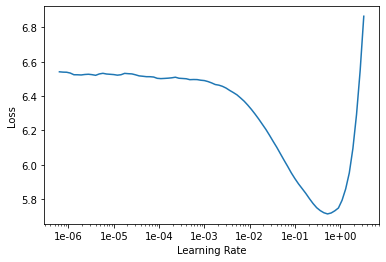

In [ ]:
learn.lr_find()
learn.recorder.plot()

We pick something closer to the point where the loss is the lowest.

**Run the language model class learner**

Taking the optimal learning rate to be 1e-2 and drop_mult to be 0.3. Dropmult parameter denotes the dropout rate which prevents the model from overfitting by dropping nodes.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.923650,4.220382,0.227827,00:16


**Unfreeze the entire model**

Unfreezing all the layers and then training the model upto 10 epochs.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.927422,3.784094,0.274330,00:20
1,3.748568,3.738375,0.279799,00:20
2,3.540906,3.768511,0.276116,00:20
3,3.240382,3.818146,0.279743,00:20
4,2.854118,3.975202,0.271280,00:20
5,2.441458,4.140917,0.266146,00:20
6,1.913332,4.336407,0.264788,00:20
7,1.422166,4.503627,0.263839,00:20
8,1.091111,4.550795,0.264583,00:20
9,0.921310,4.565560,0.263895,00:20


In [ ]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

# #2.e Setting up the Classifier

After training the language model its time to train the second part of this process that is classifier.

**Classification Dataloader**

In [ ]:
# Classifier model data
data_class = TextClasDataBunch.from_df(path, df_train, df_val, df_test, text_cols='text', label_cols='labels',vocab=data_lm.vocab) #, min_freq=1, bs=32)
data_class.save()

In [ ]:
data_class.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,1
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,0
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,0
xxbos @americanair xxmaj took a flight yesterday xxunk xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,0
"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",0


In [ ]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8198 items)
x: TextList
xxbos @usairways i called more than 25 times to redeem mile points and ca n't get through . xxmaj you advertise the miles but make them very hard to use !,xxbos @united - thanks for the rude customer service and 3 hour delay . xxmaj it really helped me timing xxunk for my afternoon meetings . xxmaj hello @delta !,xxbos @united is really getting horrible . xxmaj so much for xxunk in my kids tonight . xxmaj delta xxunk miles / status , right ? http : / / t.co / xxup xxunk,xxbos @usairways xxmaj joined xxmaj silver xxmaj preferred because i heard customer service was so great , pity i was xxunk .,xxbos @usairways thank you
y: CategoryList
0,0,0,0,1
Path: .;

Valid: LabelList (2050 items)
x: TextList
xxbos @jetblue i would like to communicate directly with a " xxmaj customer xxmaj experience " executive . xxmaj does xxmaj xxunk xxmaj xxunk have an email address ?,xxbos @usairways of course weather was a joke xxun

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


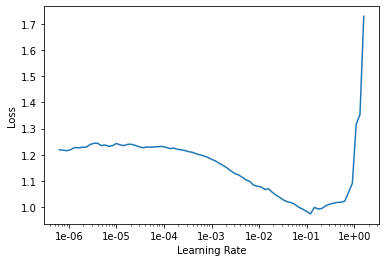

In [ ]:
learn.lr_find()
learn.recorder.plot()

# #2.f Train the Classifier

**Train the Classifer**

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.675927,0.583533,0.775610,00:09


We chose a learning quite smaller than the one showed in the graph and the accuracy has shot up to 76% which is an improvement than the supervised models which barely shows 70%.

The value (2.6^4) that I have chosen is an arbitary value and this is as suggested by Jeremy Howard in one of his tutorials.

Slowly and gradually we will freeze the layers and train the model.

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.588203,0.541432,0.787805,00:11


In [ ]:
#freeze the 3rd layer
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.539795,0.528950,0.786829,00:18


In [ ]:
#unfreezing everything after the 3 layers and train to 10 epochs
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.464788,0.524579,0.783902,00:25
1,0.465642,0.524441,0.788293,00:24
2,0.429053,0.526110,0.795122,00:25
3,0.411487,0.533325,0.791707,00:24
4,0.399416,0.533924,0.791707,00:24
5,0.372079,0.543997,0.798049,00:25
6,0.320932,0.550915,0.796585,00:23
7,0.322373,0.558484,0.794634,00:22
8,0.300517,0.560944,0.792683,00:23
9,0.331761,0.570441,0.794634,00:23


This is a great result because w got an accuracy close to 80%

# #2.g Testing and Predictions

**Testing the Model**

In [ ]:
learn.predict('your airline is very bad. The worst service')

(Category tensor(0), tensor(0), tensor([9.6597e-01, 3.1596e-04, 3.3714e-02]))

In [ ]:
learn.predict('your airline is very good. I enjoyed the service very much')

(Category tensor(2), tensor(2), tensor([3.0344e-01, 5.2301e-04, 6.9603e-01]))

It is worth noting the cofidence values of the tensor.
In the first example the confidence for class 0(Negative) is 96% for class 1 (Neutral) is close to 0 and for class 2(Positive) 3%. Thus the model predicts negative tweets with a much more confidence.

Similarly in the second example, the confidence of prediction for class 2 (Positive) is 69% which is greater as compared to other two classes. 

**Predictions**

In [ ]:
df_test['Predictions'] = df_test['text'].apply(lambda row: str(learn.predict(row)[0]))
df_test['Predictions'] = [int(x) for x in df_test['Predictions']]

While the model is predicting, grab a cup of coffee !!! 

In [ ]:
df_test.head(6)

,text,labels,Predictions
12814,@AmericanAir I'll try to have a great week onc...,0,2
1490,@united You suck. Flight delayed equipment pro...,0,0
12460,@AmericanAir is it right to provide faulty sea...,0,1
2824,@united this is besides the fact that one week...,0,0
10782,"@USAirways Yes, it was Sunday.",1,1
8420,@JetBlue OH YEAH!!! great flight down to Mexic...,2,2


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report_ulmfit = classification_report(df_test['labels'], df_test['Predictions'])
matrix_ulmfit = confusion_matrix(df_test['labels'], df_test['Predictions'])  

In [ ]:
print('Classification Report')
print(report_ulmfit)
print('\n\n Confusion Matrix')
pd.DataFrame(matrix_ulmfit)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2753
           1       0.70      0.55      0.62       930
           2       0.75      0.69      0.72       709

    accuracy                           0.80      4392
   macro avg       0.76      0.72      0.74      4392
weighted avg       0.79      0.80      0.80      4392



 Confusion Matrix


,0,1,2
0,2524,154,75
1,326,512,92
2,155,66,488


This is the final report, the accuracy and overall performance of the classifier has improved greatly.

The avg precision and recall and improved drastically as compared to previous approaches. This shows ULMFit is a better approach than standrd supervised learning techniques.

# ME-ULMFit (Metadata Enhanced ULMFit)

Using ULMFit we got an improvement in the results but can we improve it further.

ULMFit models can be improved by using metadata as suggested by Matthew Teschke in a fast.ai [discussion](https://forums.fast.ai/t/metadata-in-ulmfit-improving-accuracy-by-up-to-20/48694/3).

Adding metadata means adding some added information to the training data apart from the plain text data. In this dataset we will adding informations from some more columns like:
* Negative reason
* Retweet count
* Airline

Adding these features each training data will look like this: 

 *TWEET:- **negativereason** negativereason_no_complain **airline** airline_Virgin_America **retweet_count** retweet_count_0 **quote_text** @VirginAmerica plus you've added commercials to the experience... tacky.*

**Load the Dataset**

In [ ]:
#get the entire dataset
df = df

#This is the function to replace all NaN values with 'no complain' since they are either positive or neutral tweet.
def reason(s):
  if s == 'nan':
    return 'no complain'
  else:
    return s

df['negativereason'] = [reason(str(s)) for s in df['negativereason'].values]

In [ ]:
#Lets take out the columns that we are more interested in 
dataset = df[['text','airline_sentiment','negativereason',	'airline','retweet_count'	]]
dataset.head(3)

,text,airline_sentiment,negativereason,airline,retweet_count
0,@VirginAmerica What @dhepburn said.,neutral,no complain,Virgin America,0
1,@VirginAmerica plus you've added commercials t...,positive,no complain,Virgin America,0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,no complain,Virgin America,0


**Modify the 'text' Column to add Metadata**

In [ ]:
#concatenating the metadata tag with the respective value
def modify_metadata(input_string, tag_name):
    data = tag_name + "_".join(input_string.split(" "))
    if "," in data:
        data = data.replace(",", "")
    return data

In [ ]:
def add_metadata_joined(input_row, metadata_list):  
    tagged_text_list = []
    # Adapt the following line to get the list of tags we want to use
    for data in metadata_list:
        separator = ""
        tagged = data + " " + data + modify_metadata(str(input_row[data]),data.lower().join("_")) + " "
        tagged_text_list.append(tagged)
    q_text = 'quote_text ' + str(input_row['text'])
    tagged_text_list.append(q_text)
    joined = separator.join(tagged_text_list)
    return joined

In [ ]:
#Metadata columns that needs to be added
metadata = ['negativereason',	'airline','retweet_count'	] #,'text'	]
df['text'] = df.apply(lambda x: add_metadata_joined(x, metadata), axis=1)

#slice out the columns that are required
dataset = df[['airline_sentiment','text']]

**Encode the text labels with numbers**

In [ ]:
#encoding the labels
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(dataset['airline_sentiment'])
dataset['labels'] = encoder.transform(dataset['airline_sentiment'])
dataset = dataset[['text','labels']]
dataset.head(4)

,text,labels
0,negativereason negativereason_no_complain airl...,1
1,negativereason negativereason_no_complain airl...,2
2,negativereason negativereason_no_complain airl...,1
3,negativereason negativereason_Bad_Flight airli...,0


In [ ]:
#Examining a few Tweets
print('Tweet : \n',dataset['text'][1])

Tweet : 
 negativereason negativereason_no_complain airline airline_Virgin_America retweet_count retweet_count_0 quote_text @VirginAmerica plus you've added commercials to the experience... tacky.


In [ ]:
#clean all non-ascii characters present
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

dataset['text'] = dataset['text'].apply(clean_ascii)
dataset.head(4)

,text,labels
0,negativereason negativereason_no_complain airl...,1
1,negativereason negativereason_no_complain airl...,2
2,negativereason negativereason_no_complain airl...,1
3,negativereason negativereason_Bad_Flight airli...,0


**Test/Train/Valid Split**

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
# split data into training and validation set
df_train, df_test = train_test_split(dataset, stratify = dataset['labels'], test_size = 0.3, random_state = 42)
df_train, df_val = train_test_split(df_train, stratify = df_train['labels'], test_size = 0.2, random_state = 42)

In [ ]:
def get_language_model(df_train,df_val,df_test):
  # Language model data , a min_freq = 1 denotes that words that occur only once are given the <unk> tag during tokenization
  path = './'
  data_lm = TextLMDataBunch.from_df(path,df_train,df_val,df_test, text_cols='text',label_cols='labels')
  # Save the language and classifier model data for re-use
  data_lm.save()
  print('Setting up data for Language Model !')
  data_lm.show_batch()
  learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

  return data_lm,learn



In [ ]:
def get_classifier(df_train,df_val,df_test):
  path = './'
  # Classifier model data
  data_class = TextClasDataBunch.from_df(path, df_train, df_val, df_test, text_cols='text', label_cols='labels',vocab=data_lm.vocab) #, min_freq=1, bs=32)
  data_class.save()
  data_class.show_batch()
  learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
  learn.load_encoder('ft_enc')
  #learn.freeze()

  return data_class,learn


**Load the Language Model**

In [ ]:
data_lm,learn = get_language_model(df_train,df_val,df_test)


Setting up data for Language Model !


idx,text
0,". xxmaj hello @delta ! xxbos negativereason negativereason_late_flight airline airline_united retweet_count retweet_count_1 quote_text @united is really getting horrible . xxmaj so much for xxunk in my kids tonight . xxmaj delta xxunk miles / status , right ? http : / / t.co / xxup xxunk xxbos negativereason negativereason_customer_service_issue airline airline_us_airways retweet_count retweet_count_0 quote_text @usairways xxmaj joined xxmaj silver xxmaj preferred because i heard customer service was so great ,"
1,negativereason negativereason_late_flight airline airline_united retweet_count retweet_count_1 quote_text @united xxunk your delay is due to your own making . xxmaj we have now been back to the gate multiple times . xxmaj maybe take accountability xxbos negativereason negativereason_no_complain airline airline_southwest retweet_count retweet_count_0 quote_text @southwestair give me tickets to atlanta ! i would do anything ! xxmaj anything xxbos negativereason negativereason_customer_service_issue airline airline_us_airways retweet_count retweet_count_0 quote_text @usairways my phone has been on
2,"negativereason negativereason_no_complain airline airline_virgin_america retweet_count retweet_count_0 quote_text @virginamerica has getaway deals through xxmaj may , from $ 59 one - way . xxmaj lots of cool cities http : / / t.co / xxunk # cheapflights # farecompare xxbos negativereason negativereason_no_complain airline airline_southwest retweet_count retweet_count_0 quote_text @southwestair xxmaj maybe it is just a machine ... xxbos negativereason negativereason_customer_service_issue airline airline_us_airways retweet_count retweet_count_0 quote_text @usairways sitting here in xxup phl with"
3,united i should n't have to check my xxup cc everytime xxbos negativereason negativereason_customer_service_issue airline airline_american retweet_count retweet_count_0 quote_text @americanair xxup finally called me back ... xxup but xxup xxunk xxup spoken xxup to xxup me . xxmaj like the worst xxunk call xxup ever ! ! xxbos negativereason negativereason_customer_service_issue airline airline_delta retweet_count retweet_count_0 quote_text @jetblue we want room and food xxunk . xxmaj agents are refusing to give us
4,"up after more than 2 hours on hold . xxmaj still need that receipt ; last time it was promised , it never arrived . xxmaj help ? ! xxbos negativereason negativereason_late_flight airline airline_us_airways retweet_count retweet_count_0 quote_text @usairways is the worst ! ! xxmaj still have n't left .. xxmaj everyone missing connections . xxbos negativereason negativereason_no_complain airline airline_american retweet_count retweet_count_0 quote_text @americanair basically u right now http : /"


**Search for the optimal learning rate**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


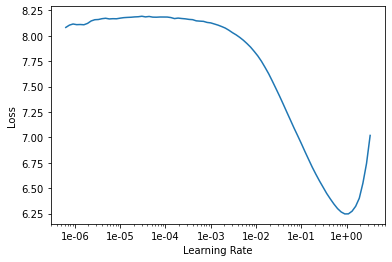

In [ ]:
#Get the optimum learning rate
learn.lr_find() #start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

Keeping the learning rate to be 1e-02 and all the other parameters are kept unchanged.

**Train the Language Model**

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.460713,3.430895,0.335149,00:19


The accuracy is aroud 33% which is twice the value we got previously. 
The Epochs is reduced to 6 to avoid overfitting.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=1e-2, moms=(0.8, 0.7))
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.172679,3.065080,0.405312,00:25
1,3.012158,3.798146,0.332173,00:25
2,2.935500,3.022995,0.398051,00:25
3,2.537619,3.007701,0.423229,00:25
4,2.036897,3.123556,0.419464,00:25
5,1.585536,3.238267,0.416161,00:25


**Create the Classifier**

In [ ]:
#Setting up the classifier
data_class,learn = get_classifier(df_train,df_val,df_test)

text,target
xxbos negativereason negativereason_no_complain airline airline_united retweet_count retweet_count_0 quote_text @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,1
xxbos negativereason negativereason_lost_luggage airline airline_united retweet_count retweet_count_0 quote_text @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,0
"xxbos negativereason negativereason_no_complain airline airline_united retweet_count retweet_count_0 quote_text @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",1
xxbos negativereason negativereason_bad_flight airline airline_united retweet_count retweet_count_0 quote_text @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # 1589 . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,0
"xxbos negativereason negativereason_late_flight airline airline_us_airways retweet_count retweet_count_0 quote_text @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",0


**Train the Classifier**

Except the number of epochs all the parameter values have been kept same.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


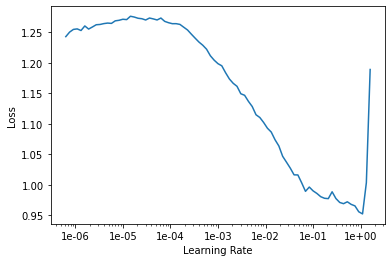

In [ ]:
learn.lr_find() #start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#unfreezing everything after the 3 layers
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.652807,0.533869,0.783415,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.569001,0.485372,0.800976,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.357358,0.190871,0.922927,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.284882,0.176156,0.933171,00:26
1,0.242811,0.154881,0.942439,00:28
2,0.190648,0.147921,0.941951,00:26
3,0.162578,0.148058,0.941951,00:27
4,0.148520,0.153659,0.943415,00:27
5,0.134237,0.152364,0.943902,00:28


At this point the accuracy on the previous approach was around 79% and here using metadata the accuracy has improved to 94% which is so far the highest we have got using all the different algorithms.

**Predictions & Metrics**

In [ ]:
#Getting the predictions
def get_predictions(row):
  #print('Predicted')
  return (learn.predict(row)[0])

df_test['Predictions'] = [get_predictions(row) for row in df_test['text'].values]
df_test['Predictions'] = [int(x) for x in df_test['Predictions']]



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
report_ulmfit_metadata = classification_report(df_test['labels'], df_test['Predictions'])
print(report_ulmfit_metadata)
#pd.DataFrame(confusion_matrix(Y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2753
           1       0.86      0.89      0.87       930
           2       0.85      0.80      0.83       709

    accuracy                           0.95      4392
   macro avg       0.90      0.90      0.90      4392
weighted avg       0.95      0.95      0.94      4392



In [ ]:
matrix_ulmfit_metadata = confusion_matrix(df_test['labels'], df_test['Predictions']) 
pd.DataFrame(matrix_ulmfit_metadata)

,0,1,2
0,2753,0,0
1,0,829,101
2,0,140,569


# Summary of all Classifiers

**Algorithm: Logistic Regression**

In [ ]:
print("The Classification Report")
print(report_lr_word_features_tfidf)
print("The Confusion Matrix")
pd.DataFrame(matrix_lr_word_features_tfidf)


The Classification Report
              precision    recall  f1-score   support

           0       0.75      0.92      0.82      2340
           1       0.45      0.26      0.33       738
           2       0.54      0.33      0.41       582

    accuracy                           0.69      3660
   macro avg       0.58      0.50      0.52      3660
weighted avg       0.65      0.69      0.66      3660

The Confusion Matrix


,0,1,2
0,2152,102,86
1,472,189,77
2,263,129,190


**Algorithm: Random Forest Classifier**

In [ ]:
print("The Classification Report")
print(report_rfc_word_features_tfidf)
print("The Confusion Matrix")
pd.DataFrame(matrix_rfc_word_features_tfidf)

The Classification Report
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2340
           1       0.45      0.29      0.35       738
           2       0.56      0.44      0.49       582

    accuracy                           0.70      3660
   macro avg       0.59      0.54      0.55      3660
weighted avg       0.67      0.70      0.67      3660

The Confusion Matrix


,0,1,2
0,2079,168,93
1,415,212,111
2,235,90,257


**Algorithm: Support Vector Machine**

In [ ]:
print("The Classification Report")
print(report_svm_word_features_tfidf)
print("The Confusion Matrix")
pd.DataFrame(matrix_svm_word_features_tfidf)

The Classification Report
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      2340
           1       0.48      0.21      0.29       738
           2       0.60      0.32      0.42       582

    accuracy                           0.70      3660
   macro avg       0.60      0.49      0.51      3660
weighted avg       0.66      0.70      0.65      3660

The Confusion Matrix


,0,1,2
0,2213,77,50
1,509,154,75
2,305,90,187


**Algorithm: ULMFit**

In [ ]:
print('Classification Report')
print(report_ulmfit)
print('\n\n Confusion Matrix')
pd.DataFrame(matrix_ulmfit)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2753
           1       0.70      0.55      0.62       930
           2       0.75      0.69      0.72       709

    accuracy                           0.80      4392
   macro avg       0.76      0.72      0.74      4392
weighted avg       0.79      0.80      0.80      4392



 Confusion Matrix


,0,1,2
0,2524,154,75
1,326,512,92
2,155,66,488


**Algorithm: ME-ULMFit (Metadata Enhanced ULMFit)**

In [ ]:
print('Classification Report')
print(report_ulmfit_metadata)
print('\n\n Confusion Matrix')
pd.DataFrame(matrix_ulmfit_metadata)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2753
           1       0.86      0.89      0.87       930
           2       0.85      0.80      0.83       709

    accuracy                           0.95      4392
   macro avg       0.90      0.90      0.90      4392
weighted avg       0.95      0.95      0.94      4392



 Confusion Matrix


,0,1,2
0,2753,0,0
1,0,829,101
2,0,140,569


It is to be noted that the precision and recall have gradually improved in every change of algorithm. Despite having class imbalance, the ULMFit Model could precict every class with a greater accuracy as evident from the improved precision and recall scores.

**Further work:**

The overall performance of the ME-ULMFit approach is the best so far. However there can be future work which I wish to do on this dataset.

* Use SeqtoSeq Models like transformers so that the context can be captured which may lead to a better generalisation.

* Try to improve the supervised learning algorithms so that they can match the performance of ULMFit.

* Extend this problem statement to another step where from a tweet the reason of unsatisfaction from the customer can be predicted. This predictions can be from the already known classes (negative reason column of the dataset) or some other classes. The idea is to capture the negative sentiment words and try to find out the reason.

# References

[1] Analytics Vidya Guide on EDA: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data

[2] Original Paper ULMFit: [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)

[3] Analytics Vidya Guide on ULMFit: https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library

[4] Fast.AI discussion on ME-ULMFit: https://forums.fast.ai/t/metadata-in-ulmfit-improving-accuracy-by-up-to-20/48694/3

[5] ME-ULMFit Official Blog by Matt Teschke, Brian Sacash : https://www.novetta.com/2019/03/introducing_me_ulmfit